# ------------------- Préambule -------------------

In [10]:
import os, pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

PGURL = os.getenv("SUPABASE_DB_URL")  # défini dans .env
engine = create_engine(PGURL)

listings = pd.read_sql(
    "SELECT id, price, minimum_nights, room_type FROM listings",
    engine
)

# 2. Statistiques descriptives -----------------------------------------------
desc = listings[["price"]].describe()  # uniquement price pour desc

# Garder seulement les annonces qui ont un calendrier publié
calendar_ids = pd.read_sql("SELECT DISTINCT listing_id FROM calendar", engine)["listing_id"]
listings = listings[listings["id"].isin(calendar_ids)].copy()
print(f"{len(listings):,} listings actifs chargés")

9,772 listings actifs chargés


# ------------------- Histogramme global (0‑500 $) -------------------

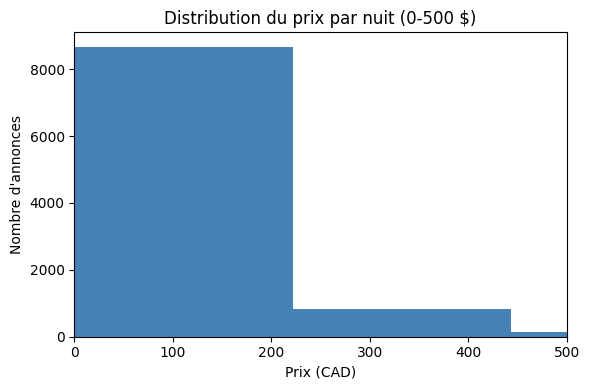

2.15% des annonces dépassent 500 $ la nuit


In [11]:
plt.figure(figsize=(6,4))
listings["price"].plot.hist(bins=60, color="steelblue")
plt.xlim(0, 500)
plt.title("Distribution du prix par nuit (0‑500 $)")
plt.xlabel("Prix (CAD)")
plt.ylabel("Nombre d'annonces")
plt.tight_layout()
plt.show()

over_500 = (listings["price"] > 500).mean()
print(f"{over_500:.2%} des annonces dépassent 500 $ la nuit")

# ------------------- Histogrammes par room_type -------------------

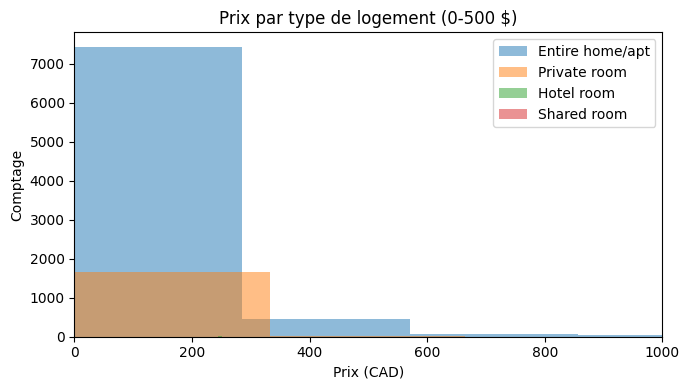

In [12]:
plt.figure(figsize=(7,4))
for rt in listings["room_type"].unique():
    subset = listings.loc[listings["room_type"] == rt, "price"]
    subset.plot.hist(bins=40, alpha=0.5, label=rt)
plt.xlim(0, 1000)
plt.title("Prix par type de logement (0‑500 $)")
plt.xlabel("Prix (CAD)")
plt.ylabel("Comptage")
plt.legend()
plt.tight_layout()
plt.show()

# ------------------- Boxplot (zoom 0‑600 $) -------------------

<Figure size 600x400 with 0 Axes>

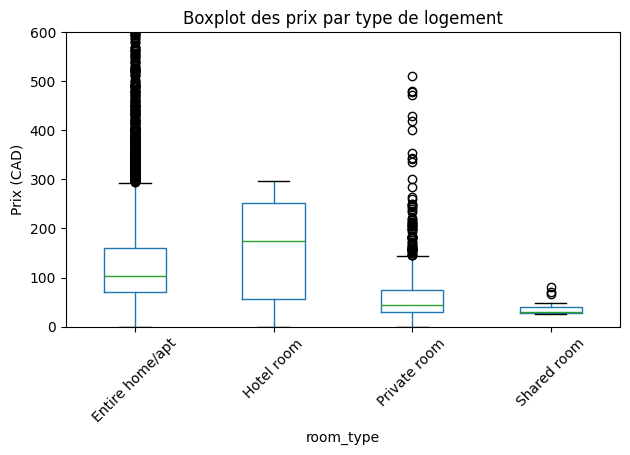

In [13]:
plt.figure(figsize=(6,4))
listings.boxplot(column="price", by="room_type", grid=False)
plt.suptitle("")
plt.ylim(0, 600)
plt.title("Boxplot des prix par type de logement")
plt.ylabel("Prix (CAD)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ------------------- Statistiques descriptives par room_type -------------------

In [14]:
stats_rt = listings.groupby("room_type")["price"].describe().round(1)
display(stats_rt[["count", "mean", "50%", "min", "max"]])

,count,mean,50%,min,max
room_type,,,,,
Entire home/apt,8059.0,148.2,104.0,0.0,11411.0
Hotel room,23.0,153.9,175.0,0.0,296.0
Private room,1672.0,68.2,44.0,0.0,13294.0
Shared room,18.0,38.1,30.5,26.0,80.0


In [21]:
from IPython.display import Markdown

# ── calculs ─────────────────────────────────────────────
median_price   = desc.loc["50%", "price"]
q1_price       = int(desc.loc["25%", "price"])
q3_price       = int(desc.loc["75%", "price"])
pct_over_500   = (listings["price"] > 500).mean()

median_min_n   = int(listings["minimum_nights"].median())   # ← direct

median_entire  = listings.loc[
    listings["room_type"] == "Entire home/apt", "price"
].median()
median_private = listings.loc[
    listings["room_type"] == "Private room", "price"
].median()

# ── génération du résumé Markdown ───────────────────────
Markdown(f"""
### Observations clés

- **Prix médian global** : `{median_price:.0f} $`  
- **Intervalle inter‑quartile** : {q1_price} $ – {q3_price} $  
- **Part des annonces > 500 $** : {pct_over_500:.2%}  
- **Minimum nights médian** : {median_min_n} nuits  
- Les `Entire home/apt` (médiane ≈ {median_entire:.0f}$) sont nettement plus chers que les `Private room` (médiane ≈ {median_private:.0f} $).
""")


### Observations clés

- **Prix médian global** : `93 $`  
- **Intervalle inter‑quartile** : 60 $ – 148 $  
- **Part des annonces > 500 $** : 2.15%  
- **Minimum nights médian** : 31 nuits  
- Les `Entire home/apt` (médiane ≈ 104$) sont nettement plus chers que les `Private room` (médiane ≈ 44 $).
